# Parameters

In [ ]:
# NOTE: smoke test run on CPU
LOG_TO_WANDB = False
LIMIT_BATCHES = 1

# LOG_TO_WANDB = True
# LIMIT_BATCHES = None

In [2]:
# Set up data paths

DATA_PATH = 'data/'

# TABLE_DATASET_FILE = 'tables_labeled/processed/labeled_5k_with-options.csv'
# IMG_DATASET_NAME = 'images_7k' # same for all 'labeled.*' datasets

# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100.csv'
# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100_conjugated.csv'
# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100_conjugated_shuffled_seed=42_fraction=1.csv'
# TABLE_DATASET_FILE = 'tables_WB_OZ_100/WB_OZ_100_conjugated_shuffled_seed=42_fraction=0.5.csv'
# IMG_DATASET_NAME = 'images_WB_OZ_100'

TABLE_DATASET_FILE = 'tables_OZ_geo_5500/processed/pairwise-splits/test=0.1_val=0.05/test.csv'
IMG_DATASET_NAME = 'images_OZ_geo_5500'

In [ ]:
# CHOSEN_MODEL_CKPT = None
# CHOSEN_MODEL_CKPT = 'siamese_contrastive.pt'
# CHOSEN_MODEL_CKPT = 'siamese_contrastive_7k.pt'
# CHOSEN_MODEL_CKPT = 'siamese_contrastive_test-f1=0.520_splitting-by-query_cc12m_rubert_tiny_ep_1.pt_best-threshold=0.19597989949748743.pt'
CHOSEN_MODEL_CKPT = 'siamese_contrastive_test-pos_acc=0.860_splitting-by-query_cc12m_rubert_tiny_ep_1.pt_best-thr=1.085.pt'

# NOTE: make sure CHOSEN_MODEL_CKPT exists in `model_configs` below
# NOTE: choose None to evaluate all models listed in `model_configs`

In [4]:
import torch

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 256 if torch.cuda.is_available() else 8

In [ ]:
# Set up model configs

model_configs = [ 

    dict(
        MODEL_CKPT = 'siamese_contrastive_test-f1=0.520_splitting-by-query_cc12m_rubert_tiny_ep_1.pt_best-threshold=0.19597989949748743.pt',
        NAME_MODEL_NAME = 'cointegrated/rubert-tiny',
        DESCRIPTION_MODEL_NAME = 'cointegrated/rubert-tiny',
        CONTRASTIVE_THRESHOLD=0.3,
        DROPOUT=0.5
    ),

    dict(
        MODEL_CKPT = 'siamese_contrastive_test-pos_acc=0.860_splitting-by-query_cc12m_rubert_tiny_ep_1.pt_best-thr=1.085.pt',
        NAME_MODEL_NAME = 'cointegrated/rubert-tiny',
        DESCRIPTION_MODEL_NAME = 'cointegrated/rubert-tiny',
        CONTRASTIVE_THRESHOLD=0.3,
        DROPOUT=0.5
    ),

    dict(
        MODEL_CKPT = 'siamese_contrastive_test-f1=0.301_splitting-by-query_cc12m_rubert_tiny_ep_1.pt',
        NAME_MODEL_NAME = 'cointegrated/rubert-tiny',
        DESCRIPTION_MODEL_NAME = 'cointegrated/rubert-tiny',
        CONTRASTIVE_THRESHOLD=0.3,
    ),

    dict(
        MODEL_CKPT = 'siamese_contrastive.pt',

        NAME_MODEL_NAME = 'cointegrated/rubert-tiny',
        # NAME_MODEL_NAME = 'DeepPavlov/distilrubert-tiny-cased-conversational-v1',

        DESCRIPTION_MODEL_NAME = 'cointegrated/rubert-tiny',
        # DESCRIPTION_MODEL_NAME = 'sergeyzh/rubert-tiny-turbo',

        CONTRASTIVE_THRESHOLD=0.3,
    ),
    
    dict(
        MODEL_CKPT = 'siamese_contrastive_7k.pt',

        NAME_MODEL_NAME = 'cointegrated/rubert-tiny',
        # NAME_MODEL_NAME = 'DeepPavlov/distilrubert-tiny-cased-conversational-v1',

        DESCRIPTION_MODEL_NAME = 'cointegrated/rubert-tiny',

        CONTRASTIVE_THRESHOLD=0.3,
    ),
    
    
    # # TODO: find correct name/description names
    # dict(
    #     MODEL_CKPT = 'siamese_contrastive_1gpu.pt',

    #     NAME_MODEL_NAME = 'cointegrated/rubert-tiny',
    #     # NAME_MODEL_NAME = 'DeepPavlov/distilrubert-tiny-cased-conversational-v1',

    #     # DESCRIPTION_MODEL_NAME = 'sergeyzh/rubert-tiny-turbo',
    #     DESCRIPTION_MODEL_NAME = 'cointegrated/rubert-tiny',

    #     CONTRASTIVE_THRESHOLD=0.3,
    # ),
]

In [41]:
model_configs = {config['MODEL_CKPT']: config for config in model_configs}
print('Available models:')
list(model_configs.keys())

Available models:


['siamese_contrastive_test-f1=0.520_splitting-by-query_cc12m_rubert_tiny_ep_1.pt_best-threshold=0.19597989949748743.pt',
 'siamese_contrastive_test-pos_acc=0.860_splitting-by-query_cc12m_rubert_tiny_ep_1.pt_best-thr=1.085.pt',
 'siamese_contrastive.pt',
 'siamese_contrastive_7k.pt']

# Log into services

In [7]:
try:
    import dotenv
except ImportError:
    !pip install python-dotenv

In [8]:
# Use tokens from .env

import os
from dotenv import load_dotenv

import huggingface_hub
import wandb

load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")
huggingface_hub.login(token=HF_TOKEN)

if LOG_TO_WANDB:
    WANDB_API_KEY = os.getenv("WANDB_API_KEY")
    wandb.login(key=WANDB_API_KEY)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# Imports

In [9]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"


from timm import create_model
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
from torch import optim, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
# from torchinfo import summary
import transformers
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer,\
        get_linear_schedule_with_warmup
from transformers import AutoModel, AutoTokenizer

import cv2

from PIL import Image
from tqdm.auto import tqdm

import json
from itertools import product

# import datasets
# from datasets import Dataset, concatenate_datasets
import argparse
import requests

from io import BytesIO
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import more_itertools

# Source code

### RuCLIPtiny

In [10]:
class RuCLIPtiny(nn.Module):
    def __init__(self, name_model_name: str):
        """
        Initializes the RuCLIPtiny module using the provided name model.
        """
        super().__init__()
        self.visual = create_model('convnext_tiny',
                                   pretrained=False,  # set True if you want pretrained weights
                                   num_classes=0,
                                   in_chans=3)       # output: e.g. 768-dim features
        
        self.transformer = AutoModel.from_pretrained(name_model_name)
        name_model_output_size = self.transformer.config.hidden_size  # inferred dynamically
        self.final_ln = nn.Linear(name_model_output_size, 768)         # project to 768 dims
        self.logit_scale = nn.Parameter(torch.ones([]) * torch.log(torch.tensor(1/0.07)))
    
    @property
    def dtype(self):
        return self.visual.stem[0].weight.dtype

    def encode_image(self, image: torch.Tensor) -> torch.Tensor:
        return self.visual(image.type(self.dtype))

    def encode_text(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        x = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        # use the CLS token (first token)
        x = x.last_hidden_state[:, 0, :]
        x = self.final_ln(x)
        return x

    def forward(self, image: torch.Tensor, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        image_features = self.encode_image(image)
        text_features = self.encode_text(input_ids, attention_mask)
        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()
        return logits_per_image, logits_per_text


In [11]:
def get_transform():
    return transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        lambda image: image.convert("RGB"),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

class Tokenizers:
    def __init__(self, name_model_name: str, description_model_name: str):
        self.name_tokenizer = AutoTokenizer.from_pretrained(name_model_name)
        self.desc_tokenizer = AutoTokenizer.from_pretrained(description_model_name)

    def tokenize_name(self, texts, max_len=77):
        tokenized = self.name_tokenizer.batch_encode_plus(
            texts,
            truncation=True,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return torch.stack([tokenized["input_ids"], tokenized["attention_mask"]])

    def tokenize_description(self, texts, max_len=77):
        tokenized = self.desc_tokenizer(
            texts,
            truncation=True,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return torch.stack([tokenized["input_ids"], tokenized["attention_mask"]])


In [12]:
class SiameseRuCLIPDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir: str, name_model_name: str, description_model_name: str, df=None, labels=None, df_path=None):
        """
        Dataset requires the concrete models' names for tokenization.
        """
        assert os.path.isdir(images_dir), f"Image dir does not exist: '{self.images_dir}'"

        self.df = pd.read_csv(df_path) if df_path is not None else df
        self.labels = labels
        self.images_dir = images_dir
        self.tokenizers = Tokenizers(name_model_name, description_model_name)
        self.transform = get_transform()
        self.max_len = 77

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Tokenize names
        name_tokens = self.tokenizers.tokenize_name([str(row.name_first), str(row.name_second)], max_len=self.max_len)
        name_first = name_tokens[:, 0, :]  # [input_ids, attention_mask]
        name_second = name_tokens[:, 1, :]
        # Tokenize descriptions
        desc_tokens = self.tokenizers.tokenize_description([str(row.description_first), str(row.description_second)])
        desc_first = desc_tokens[:, 0, :]
        desc_second = desc_tokens[:, 1, :]
        # Process images
        im_first_path = os.path.join(self.images_dir, row.image_name_first)
        im_first = cv2.imread(im_first_path)
        im_first = cv2.cvtColor(im_first, cv2.COLOR_BGR2RGB)
        im_first = Image.fromarray(im_first)
        im_first = self.transform(im_first)
        im_second_path = os.path.join(self.images_dir, row.image_name_first)
        im_second = cv2.imread(os.path.join(im_second_path))
        im_second = cv2.cvtColor(im_second, cv2.COLOR_BGR2RGB)
        im_second = Image.fromarray(im_second)
        im_second = self.transform(im_second)
        label = self.labels[idx]
        return im_first, name_first, desc_first, im_second, name_second, desc_second, label

    def __len__(self):
        return len(self.df)

### SiameseRuCLIP

In [28]:
def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

class SiameseRuCLIP(nn.Module):
    def __init__(self,
                 device: str,
                 name_model_name: str,
                 description_model_name: str,
                 preload_model_name: str = None,
                 models_dir: str = None,
                 dropout: float = None):
        """
        Initializes the SiameseRuCLIP model.
        Required parameters:
          - models_dir: directory containing saved checkpoints.
          - name_model_name: model name for text (name) branch.
          - description_model_name: model name for description branch.
        """
        super().__init__()
        device = torch.device(device)

        # Initialize RuCLIPtiny
        self.ruclip = RuCLIPtiny(name_model_name)
        if preload_model_name is not None:
            std = torch.load(
                os.path.join(models_dir, preload_model_name),
                weights_only=True,
                map_location=device
            )
            self.ruclip.load_state_dict(std)
            self.ruclip.eval()
        self.ruclip = self.ruclip.to(device)

        # Initialize the description transformer
        self.description_transformer = AutoModel.from_pretrained(description_model_name)
        self.description_transformer = self.description_transformer.to(device)

        # Determine dimensionality
        vision_dim = self.ruclip.visual.num_features
        name_dim = self.ruclip.final_ln.out_features
        desc_dim = self.description_transformer.config.hidden_size
        self.hidden_dim = vision_dim + name_dim + desc_dim
        self.dropout = dropout

        # Define MLP head with optional dropout
        layers = [
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.ReLU(),
            *( [nn.Dropout(self.dropout)] if self.dropout is not None else [] ),
            nn.Linear(self.hidden_dim // 2, self.hidden_dim // 4),
        ]
        self.head = nn.Sequential(*layers).to(device)


    def encode_image(self, image):
        return self.ruclip.encode_image(image)

    def encode_name(self, name):
        return self.ruclip.encode_text(name[:, 0, :], name[:, 1, :])

    def encode_description(self, desc):
        last_hidden_states = self.description_transformer(desc[:, 0, :], desc[:, 1, :]).last_hidden_state
        attention_mask = desc[:, 1, :]
        return average_pool(last_hidden_states, attention_mask)

    def get_final_embedding(self, im, name, desc):
        image_emb = self.encode_image(im)
        name_emb = self.encode_name(name)
        desc_emb = self.encode_description(desc)

        # Concatenate the embeddings and forward through the head
        combined_emb = torch.cat([image_emb, name_emb, desc_emb], dim=1)
        final_embedding = self.head(combined_emb)
        return final_embedding

    def forward(self, im1, name1, desc1, im2, name2, desc2):
        out1 = self.get_final_embedding(im1, name1, desc1)
        out2 = self.get_final_embedding(im2, name2, desc2)
        return out1, out2

# Evaluation loop

## Run evaluation

In [14]:
# Download models' weights & text/image datasets

from huggingface_hub import snapshot_download
from pathlib import Path

REPO_ID = "INDEEPA/clip-siamese"
LOCAL_DIR = Path("data/train_results")
LOCAL_DIR.mkdir(parents=True, exist_ok=True)

snapshot_download(
    repo_id=REPO_ID,
    repo_type='dataset',
    local_dir='data',
    allow_patterns=[
        "train_results/siamese_contrastive*.pt",
        TABLE_DATASET_FILE,
        f"{IMG_DATASET_NAME}.zip"
    ],
)

!unzip -n -q data/{IMG_DATASET_NAME}.zip -d data/

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

test.csv:   0%|          | 0.00/8.58M [00:00<?, ?B/s]

In [15]:
# Load data

labeled = pd.read_csv(DATA_PATH + TABLE_DATASET_FILE)
images_dir = DATA_PATH + IMG_DATASET_NAME

y = 1 - labeled.label.values # target = minimal euclidean distance = 0
X = labeled.drop(columns='label').copy()

def load_data(model_config):
    test_ds = SiameseRuCLIPDataset(
        images_dir,
        model_config['NAME_MODEL_NAME'], 
        model_config['DESCRIPTION_MODEL_NAME'], 
        X, y
    )
    test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)
    return test_dl

In [16]:
# model_config = model_configs[CHOSEN_MODEL_CKPT] # choose a particular config for debugging
# test_dl = load_data(model_config)
# im1, name1, desc1, im2, name2, desc2, label = next(iter(test_dl))
# im1, name1, desc1, im2, name2, desc2, label = im1.to(DEVICE), name1.to(DEVICE), desc1.to(DEVICE), im2.to(DEVICE), name2.to(DEVICE), desc2.to(DEVICE), label.to(DEVICE)

In [36]:
# Load model

from pathlib import Path

def load_model(model_config):
    ckpt_name = model_config['MODEL_CKPT']
    model_ckpt_path = Path(DATA_PATH) / 'train_results' / ckpt_name
    std = torch.load(model_ckpt_path, map_location=DEVICE)

    # Initialize the model using the configuration.
    model = SiameseRuCLIP(
        name_model_name=model_config["NAME_MODEL_NAME"],
        description_model_name=model_config["DESCRIPTION_MODEL_NAME"],
        device=DEVICE,
        dropout=model_config.get('DROPOUT', None)
    )

    model.load_state_dict(std)
    return model

In [44]:
# model = load_model(model_config)
# out1, out2 = model(im1, name1, desc1, im2, name2, desc2) 

In [19]:
import numpy as np
import torch

def compute_embeddings(model, valid_loader, device=DEVICE, limit_batches=None):
    """
    Compute and return the embeddings for all image pairs in the validation set.
    
    Args:
        model: The embedding model.
        valid_loader: DataLoader for the validation set.
        device: The device to run the model on.
    
    Returns:
        embeddings1 (np.ndarray): Embeddings for the first image in the pair.
        embeddings2 (np.ndarray): Embeddings for the second image in the pair.
        labels (np.ndarray): Ground truth labels (1 for similar, 0 for not).
    """
    all_embeddings1 = []
    all_embeddings2 = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            if limit_batches is not None and batch_idx > limit_batches-1:
                break

            im1, name1, desc1, im2, name2, desc2, label = data
            im1, name1, desc1, im2, name2, desc2, label = (
                im1.to(device), name1.to(device), desc1.to(device),
                im2.to(device), name2.to(device), desc2.to(device), label.to(device)
            )
            out1, out2 = model(im1, name1, desc1, im2, name2, desc2)

            # Store embeddings and labels
            all_embeddings1.append(out1.cpu().numpy())
            all_embeddings2.append(out2.cpu().numpy())
            all_labels.append(label.cpu().numpy())

    # Convert lists to numpy arrays
    embeddings1 = np.concatenate(all_embeddings1, axis=0)
    embeddings2 = np.concatenate(all_embeddings2, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    return embeddings1, embeddings2, labels

In [20]:
# embs_first, embs_second, labels = compute_embeddings(model, test_dl, DEVICE, LIMIT_BATCHES)
# embs_first.shape, embs_second.shape

In [21]:
# Helper function for computing accuracy

def evaluate_pair(output1, output2, target, threshold, return_preds=False):
    euclidean_distance = F.pairwise_distance(output1, output2)
    # меньше границы, там где будет True — конкуренты
    cond = euclidean_distance < threshold
    pos_sum = 0
    neg_sum = 0
    pos_acc = 0
    neg_acc = 0

    for i in range(len(cond)):
        # 1 значит не конкуренты
        if target[i]:
            neg_sum+=1
            # 0 в cond значит дальше друг от друга чем threshold
            if not cond[i]:
                neg_acc+=1
        elif not target[i]:
            pos_sum+=1
            if cond[i]:
                pos_acc+=1

    if return_preds:
        return pos_acc, pos_sum, neg_acc, neg_sum, cond
    else:
        return pos_acc, pos_sum, neg_acc, neg_sum

In [22]:
# %% [modified] Function to compute and save extended dataframe with predictions
def compute_and_save_extended_predictions(
    embs_first,
    embs_second,
    labels,
    labeled_df,
    threshold,
    model_name: str,
    source_file_path: str = 'extended_predictions.csv',
    include_raw_preds: bool = True
) -> 'pd.DataFrame':
    """
    Compute contrastive scores and prediction margins, then save an extended DataFrame.

    If the DataFrame is longer than the embeddings, it will be truncated to match.

    Args:
        embs_first: array-like of first embeddings.
        embs_second: array-like of second embeddings.
        labels: array-like of boolean ground-truth labels.
        labeled_df: pandas DataFrame containing the original data.
        threshold: float, contrastive distance threshold.
        output_path: str, path to write the CSV.
        include_raw_preds: bool, whether to include raw model predictions in the output.

    Returns:
        extended_df: pandas DataFrame with added columns:
            - 'score': euclidean distance between embedding pairs.
            - f'pred_margin={threshold}': threshold minus score.
            - 'prediction' (optional): raw predictions from evaluate_pair.
    """
    import torch
    from torch.nn.functional import pairwise_distance

    # Ensure inputs align: truncate DataFrame if longer than embeddings
    n = len(embs_first)
    dataset_frac = round(n / len(labeled_df), 2)
    if len(labeled_df) > n:
        labeled_df = labeled_df.iloc[:n].reset_index(drop=True)

    # Convert inputs to tensors
    embs_first_tensor = torch.tensor(embs_first, dtype=torch.float)
    embs_second_tensor = torch.tensor(embs_second, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.bool)

    # Get raw model predictions
    *_, preds_tensor = evaluate_pair(
        embs_first_tensor,
        embs_second_tensor,
        labels_tensor,
        threshold,
        return_preds=True
    )

    # Compute euclidean distances as scores
    distances = pairwise_distance(embs_first_tensor, embs_second_tensor).cpu().numpy()

    # Build extended DataFrame
    extended_df = labeled_df.copy()
    extended_df['siamese_sim'] = distances
    extended_df[f'pred_margin={threshold}'] = threshold - distances

    # Optionally include raw predictions
    if include_raw_preds:
        extended_df['prediction'] = preds_tensor.cpu().numpy()

    # Save to CSV
    output_path = Path(source_file_path).parent / (Path(source_file_path).stem + f'_evaluation-threshold={threshold}_dataset-frac={dataset_frac}' + f'_model={model_name}' + '.csv')
    extended_df.to_csv(output_path, index=False)
    print(f"Extended predictions saved to '{output_path}'")

    return extended_df

# extended_df = compute_and_save_extended_predictions(
#     embs_first, embs_second, labels, labeled,
#     model_config['CONTRASTIVE_THRESHOLD'],
#     model_config['MODEL_CKPT'],
#     source_file_path=DATA_PATH + TABLE_DATASET_FILE
# )

In [23]:
# Get evaluation score

import torch
import torch.nn.functional as F

def validation(embeddings1, embeddings2, labels, threshold):
    """
    Compute accuracy for precomputed embeddings using evaluate_pair().

    Args:
        embeddings1 (np.ndarray): Precomputed embeddings for the first image in the pair.
        embeddings2 (np.ndarray): Precomputed embeddings for the second image in the pair.
        labels (np.ndarray): Ground truth labels (True for non-competitor, False for competitor).
        threshold (float): Distance threshold for determining similarity.

    Returns:
        pos_accuracy (float): Accuracy for competitor samples (label == False).
        neg_accuracy (float): Accuracy for non-competitor samples (label == True).
    """
    # Convert NumPy arrays to torch tensors
    embeddings1_tensor = torch.tensor(embeddings1, dtype=torch.float)
    embeddings2_tensor = torch.tensor(embeddings2, dtype=torch.float)
    # Convert labels to bool if they're not already boolean
    labels_tensor = torch.tensor(labels, dtype=torch.bool)

    # Use evaluate_pair to compute counts of correct predictions
    pos_acc, pos_sum, neg_acc, neg_sum = evaluate_pair(embeddings1_tensor, embeddings2_tensor, labels_tensor, threshold)

    # Calculate accuracies; pos corresponds to competitor samples (label False) and neg to non-competitor (label True)
    pos_accuracy = pos_acc / pos_sum if pos_sum > 0 else None
    neg_accuracy = neg_acc / neg_sum if neg_sum > 0 else None

    return pos_accuracy, neg_accuracy

In [24]:
# pos_acc, neg_acc = validation(
#     embs_first, embs_second, labels,
#     model_config['CONTRASTIVE_THRESHOLD']
# )

# pos_acc, neg_acc

In [25]:
# Compute and plot ROC-AUC

import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

def compute_roc_auc_values(embeddings1, embeddings2, labels):
    """
    Compute ROC-AUC for the precomputed embeddings.
    
    Args:
        embeddings1 (np.ndarray): Precomputed embeddings for the first image in the pair.
        embeddings2 (np.ndarray): Precomputed embeddings for the second image in the pair.
        labels (np.ndarray): Ground truth labels (1 for similar, 0 for not).
    
    Returns:
        fpr (np.ndarray): False Positive Rate.
        tpr (np.ndarray): True Positive Rate.
        roc_auc (float): Area under the ROC curve.
    """
    # Calculate Euclidean distances between embeddings
    euclidean_distances = np.linalg.norm(embeddings1 - embeddings2, axis=1)

    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(labels, euclidean_distances)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

import matplotlib.pyplot as plt

def get_roc_curve_plot(fpr, tpr, roc_auc, model_ckpt):
    """
    Generate and return a Matplotlib figure and axis with the ROC curve plotted.

    Args:
        fpr (np.ndarray): False Positive Rate.
        tpr (np.ndarray): True Positive Rate.
        roc_auc (float): Area under the ROC curve.
    
    Returns:
        fig (matplotlib.figure.Figure): The generated figure.
        ax (matplotlib.axes.Axes): The generated axes.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve — {model_ckpt}')
    ax.legend(loc='lower right')
    ax.grid(True)
    return fig

# fpr, tpr, roc_auc = compute_roc_auc_values(embs_first, embs_second, labels)
# fig = get_roc_curve_plot(fpr, tpr, roc_auc)
# plt.show()

In [26]:
import wandb

def log_to_wandb(
    model_config, pos_acc, neg_acc,
    roc_auc = None,
    plot_fig=None
):
    """
    Log metrics (and optionally a plot) to Weights & Biases.
    
    Args:
        model_config (dict): Model configuration and related parameters.
        pos_acc (float): Accuracy for competitor samples (label == False).
        neg_acc (float): Accuracy for non-competitor samples (label == True).
        plot_fig (matplotlib.figure.Figure, optional): Figure object to be logged.
    """
    wandb.init(
        project="product-matching",
        entity="overfit1010",
        name=f"test-{model_config['MODEL_CKPT']}",
        config={
            "table_dataset_file": TABLE_DATASET_FILE,
            "img_dataset_name": IMG_DATASET_NAME,
            "model_ckpt": model_config['MODEL_CKPT'],
            "name_model_name": model_config['NAME_MODEL_NAME'],
            "description_model_name": model_config['DESCRIPTION_MODEL_NAME'],
            "threshold": model_config['CONTRASTIVE_THRESHOLD'],
            "roc_auc": roc_auc,
            "model_type": "siamese-contrastive",
            "run_type": "test"
        }
    )

    test_weighted_accuracy = None
    if pos_acc is not None and neg_acc is not None:
        test_weighted_accuracy = (pos_acc + neg_acc) / 2

    wandb.summary["test.pos_acc"] = pos_acc
    wandb.summary["test.neg_acc"] = neg_acc
    wandb.summary["test.weighted_acc"] = test_weighted_accuracy

    # Only log the plot if the ROC-AUC is valid (not np.nan)
    if not np.isnan(roc_auc):  # Check if roc_auc is not NaN
        if plot_fig is not None:
            # Log the ROC curve plot as an image
            wandb.log({"roc_curve": wandb.Image(plot_fig)})

    wandb.finish()

# log_to_wandb(model_config, pos_acc, neg_acc, roc_auc, fig)

  0%|          | 0/81 [00:00<?, ?it/s]

Extended predictions saved to 'data/tables_OZ_geo_5500/processed/pairwise-splits/test=0.1_val=0.05/test_evaluation-threshold=0.3_dataset-frac=0.01_model=siamese_contrastive_test-f1=0.520_splitting-by-query_cc12m_rubert_tiny_ep_1.pt_best-threshold=0.19597989949748743.pt.csv'
{'model_ckpt': 'siamese_contrastive_test-f1=0.520_splitting-by-query_cc12m_rubert_tiny_ep_1.pt_best-threshold=0.19597989949748743.pt',
 'neg_acc': 0.86,
 'pos_acc': 0.0,
 'roc_auc': np.float64(0.86)}


,model_ckpt,pos_acc,neg_acc,roc_auc
0,siamese_contrastive_test-f1=0.520_splitting-by...,0.0,0.86,0.86


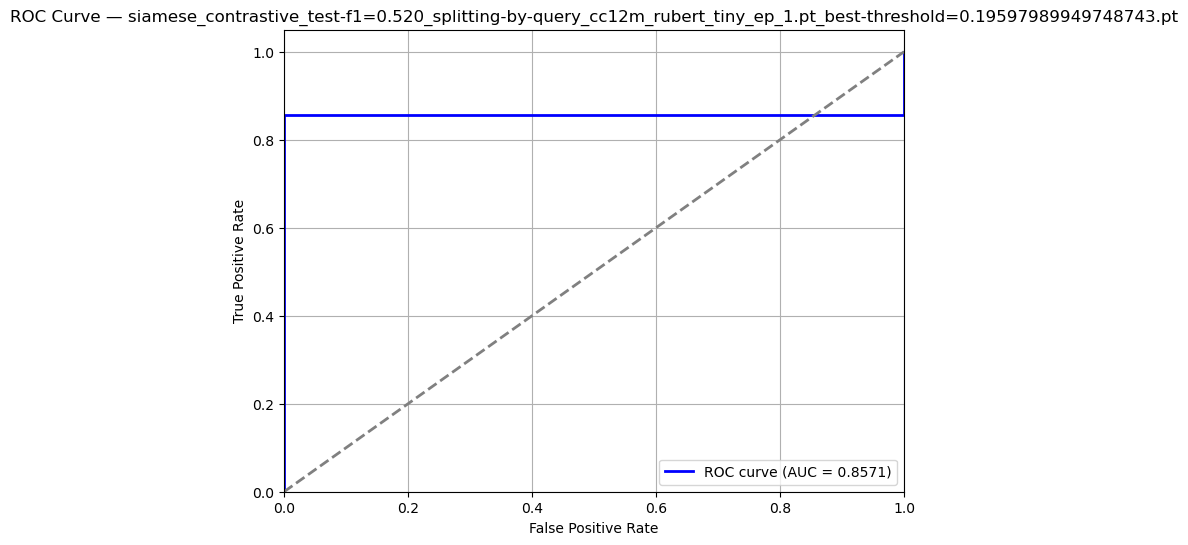

In [43]:
from pprint import pprint

if CHOSEN_MODEL_CKPT is not None:
    configs_to_evaluate = [model_configs[CHOSEN_MODEL_CKPT]]
else:
    configs_to_evaluate = model_configs

results = []
for model_config in configs_to_evaluate:
    model = load_model(model_config)
    test_dl = load_data(model_config)
    embs_first, embs_second, labels = compute_embeddings(
        model, 
        test_dl,
        device=DEVICE,
        limit_batches=LIMIT_BATCHES # smoke test if needed
    )
    
    extended_df = compute_and_save_extended_predictions(
        embs_first, embs_second, labels, labeled,
        model_config['CONTRASTIVE_THRESHOLD'],
        model_config['MODEL_CKPT'],
        source_file_path=DATA_PATH + TABLE_DATASET_FILE
    )

    pos_acc, neg_acc = validation(
        embs_first, embs_second, labels,
        model_config['CONTRASTIVE_THRESHOLD']
    )

    # TODO: compute f1-score
    fpr, tpr, roc_auc = compute_roc_auc_values(embs_first, embs_second, labels)
    fig = get_roc_curve_plot(fpr, tpr, roc_auc, model_config['MODEL_CKPT'])
    
    # Collect results for this model configuration
    result = {
        'model_ckpt': model_config['MODEL_CKPT'],
        'pos_acc': round(pos_acc, 2),
        'neg_acc': round(neg_acc, 2),
        'roc_auc': round(roc_auc, 2)
    }
    
    pprint(result)
    results.append(result)
    
    if LOG_TO_WANDB:
        log_to_wandb(model_config, pos_acc, neg_acc, roc_auc, fig)
    else:
        plt.plot()

# Convert results to a DataFrame and display the first few rows
results = pd.DataFrame(results)
display(results)